In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from tqdm import tqdm

In [3]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(3, 20)
        # self.fc2 = nn.Linear(20, 20)
        self.fc3 = nn.Linear(20, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        # x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# torch.autograd.grad(outputs, inputs, create_graph = True)
# x = [t, s, q]
def mu_hat(x):
    return (1. + x[1]) / (1. + x[2])

# dtV + max_pi [ \sum_k mu_hat(s_k, q_k) ds_kV + dq_kV + sigma_hat^2/2 + mu_hat(s_k, q_k) ]
def hjb_term(net, x):
    outputs = net(x)
    grad_v = torch.autograd.grad(outputs, x, create_graph = True)[0]
    # print(grad_v)
    return grad_v[0] + torch.max(mu_hat(x) * (grad_v[1] + 1.) + grad_v[2] + 0.5, torch.tensor([0.5]))


def train(net, n, reg, lr):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=lr)

    for i in tqdm(range(n)):
        t = torch.rand(1)
        q = t * torch.rand(1)
        s = 3 * torch.rand(1)
        x = torch.tensor([t, s, q], requires_grad = True)
        bdry_x = torch.tensor([1., s, q], requires_grad = True)

        optimizer.zero_grad()
        loss = torch.pow(hjb_term(net, x), 2) + reg * torch.pow(net(bdry_x), 2)
        loss.backward()
        optimizer.step()

In [4]:
net = Net()
n = 10000
lr = 0.1
reg = 0.1

train(net, n, reg, lr)

100%|██████████| 10000/10000 [00:07<00:00, 1344.29it/s]


In [5]:
net(torch.tensor([1., 0.5, 0.5]))

tensor([-6.4880e-43], grad_fn=<AddBackward0>)

In [6]:
def policy(net, x):
    # 0 --> unknown arm, 1 --> known arm
    outputs = net(x)
    grad_v = torch.autograd.grad(outputs, x, create_graph = True)[0]
    return torch.argmax(torch.tensor([mu_hat(x) * (grad_v[1] + 1.) + grad_v[2] + 0.5, 0.5]))

In [7]:
policy(net, torch.zeros(3, requires_grad=True))

tensor(0)

In [8]:
import numpy as np

means = torch.arange(0, 1.05, 0.05)
reps = 100
rwds = np.zeros((len(means), reps))

n = 100
for r in tqdm(range(reps)):
    for j, mean in enumerate(means):
        s = 0.
        q = 0.
        for i in range(n):
            x = torch.tensor([i / n, s, q], requires_grad = True)
            arm = policy(net, x)
            if arm == 1:
                rwds[j, r] = s + (1. - i / n) * 0.5
                break
            else:
                s += np.random.binomial(1, mean) / n
                q += 1. / n
                if i == n - 1:
                    rwds[j, r] = s
            

100%|██████████| 100/100 [00:46<00:00,  2.15it/s]


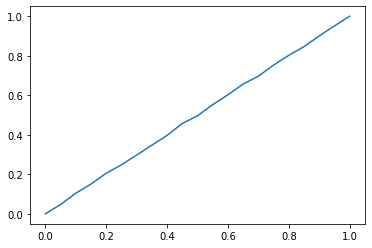

In [10]:
import matplotlib.pyplot as plt
mean_rwd = np.mean(rwds, axis=1)
plt.plot(means, mean_rwd)
plt.show()

In [11]:
policy(net, torch.zeros(3, requires_grad=True))

tensor(0)

In [12]:
net(torch.tensor([1.,0.5,0.5], requires_grad=True))

tensor([-6.4880e-43], grad_fn=<AddBackward0>)

In [13]:
policy(net, torch.tensor([0.9, 0., 0.7], requires_grad=True))

tensor(0)